In [229]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from config import *
%matplotlib inline

In [230]:
data = pd.read_csv(os.path.expanduser(PROCESSED_DATA_FOLDER+PROCESSED_FILE),
                   parse_dates=['check_date', 'departure_time'])

In [231]:
#data = data.sort_values('check_date')

In [232]:
data.head()

,Unnamed: 0,check_date,from,to,flight_date,departure_time,arrival_time,flight_number,price,price_gbp,timestamp_ms
0,1,2015-07-20 14:00:01.250,EDI,GDN,2015-10-20,2015-10-20 16:35:00,2015-10-20 19:55,FR7921,23.99,23.99,1.437401e+12
1,117,2015-07-20 14:00:01.250,STN,POZ,2015-10-16,2015-10-16 11:20:00,2015-10-16 14:25,FR2336,33.99,33.99,1.437401e+12
2,118,2015-07-20 14:00:01.250,STN,POZ,2015-10-17,2015-10-17 11:20:00,2015-10-17 14:25,FR2336,18.99,18.99,1.437401e+12
3,119,2015-07-20 14:00:01.250,STN,POZ,2015-10-18,2015-10-18 11:20:00,2015-10-18 14:25,FR2336,22.99,22.99,1.437401e+12
4,120,2015-07-20 14:00:01.250,STN,POZ,2015-10-19,2015-10-19 11:20:00,2015-10-19 14:25,FR2336,18.99,18.99,1.437401e+12


In [233]:
data['check_date'].describe()

count                           9003
unique                            57
top       2015-08-30 09:00:01.618000
freq                             180
first     2015-07-20 14:00:01.250000
last      2015-10-08 21:00:01.563000
Name: check_date, dtype: object

In [234]:
# TO DATETIME
data['departure_time'] = pd.to_datetime(data['departure_time'])

In [235]:
# EXPAND 
data['days_to_flight'] = data.apply(lambda x: (x['departure_time'] - x['check_date']).days, axis=1)

In [265]:
# NORMALISE PRICE (subtract init, divide by init)
price_init = data.sort_values('check_date').groupby('departure_time').first()['price_gbp'].to_dict()

data['price_init'] = data.apply(lambda x: price_init[x['departure_time']], axis=1)
data['price_offset'] = data['price_gbp'] - data['price_init']
data['price_norm'] = data['price_gbp']/data['price_init']
# data['price_norm'] = data['price_offset']/data['price_init']

data['log_price_norm'] = np.log(data['price_norm'])

In [237]:
flights = list(data['flight_number'].unique())
colors = dict(zip(flights, sns.color_palette('muted', len(flights))))
data['flight_color'] = data['flight_number'].apply(lambda f: colors[f])

In [238]:
# departures = list(data['departure_time'].unique())
departures = [pd.Timestamp(date) for date in data['departure_time'].unique()]
colors = dict(zip(departures, sns.color_palette('muted', len(departures))))
data['departure_color'] = data['departure_time'].apply(lambda f: colors[f])


In [239]:
a = departures[0]
pd.Timestamp(a)

Timestamp('2015-10-20 16:35:00')

In [240]:
def plot_days_to_flight_scatter(df, price='price_gbp', color_map='flight_color'):
    df.plot.scatter('days_to_flight', price,
#                     logx=True,
#                     logy=True,
                    s=50,
                    c=df[color_map])

## Is price vs time left U-shaped?
If so, then it's best to buy at the minimum. We need longer period of data to check this. Flights with numbers 8 and 9 have trough ~ 40 days before flight. price_norm works well for plots, I guess we may want to fit price = exp(days),

In [288]:
flights = data['flight_number'].unique()
i = 0

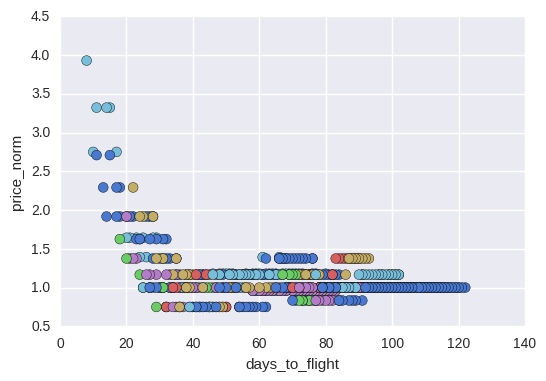

In [289]:
plot_days_to_flight_scatter(data[data['flight_number']==flights[i]], price='price_norm', color_map='departure_color')
i += 1

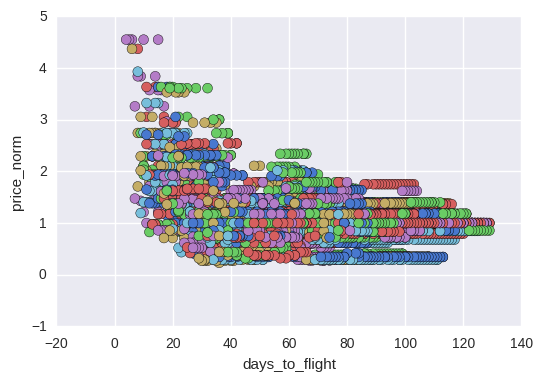

In [268]:
plot_days_to_flight_scatter(data, price='price_norm', color_map='departure_color')


## Price vs time to flight plots
Some data series seem to be wrong (e.g. i={15, 18, 27}) -- is this two separate flights merged? See plot below. What causes this bug.

In [269]:
departs = data['departure_time'].unique()
i = 0

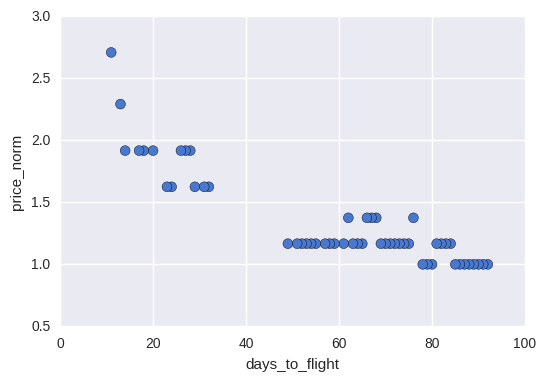

In [270]:
plot_days_to_flight_scatter(data[data['departure_time'] == departs[i]], price='price_norm', color_map='departure_color')
i += 1

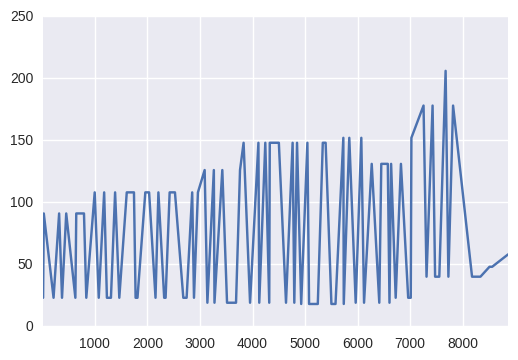

In [271]:
data[data['departure_time'] == departs[15]]['price'].plot()
# what's this? :O Two flights?

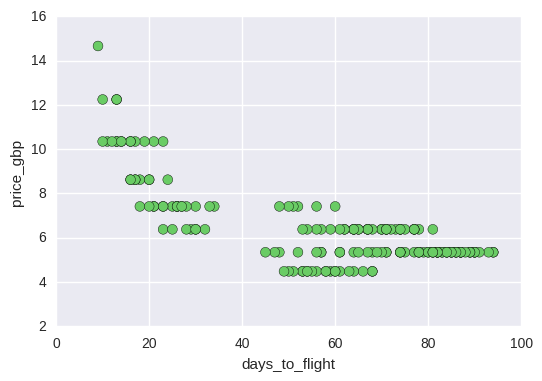

In [247]:
plot_days_to_flight_scatter(data[data['flight_number'] == 'FR6619'])

## Check this out!
Before we apply offset/normalisation to prices flight number or city tell us a lot about the price:

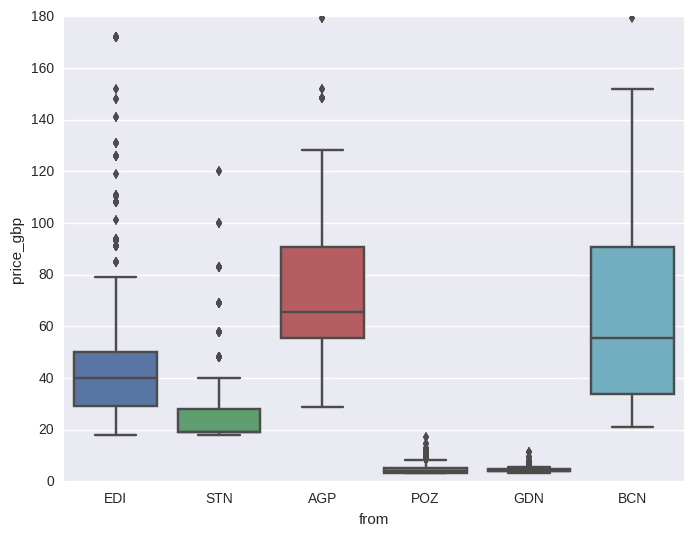

In [272]:
var_ctrl = 'from'
var_dep = 'price_gbp'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var_ctrl, y=var_dep, data=data)

However, after we apply the correction, there is little to extract from those variables:

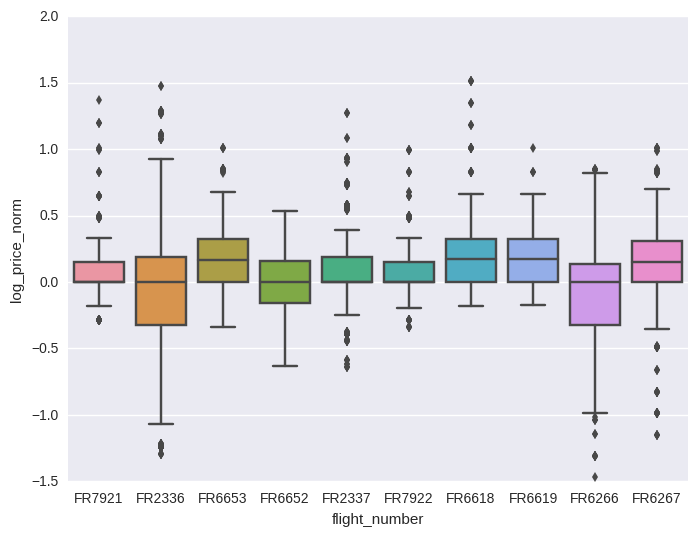

In [368]:
var_ctrl = 'from'
var_ctrl = 'flight_number'
var_dep = 'log_price_norm'
# var_dep = 'price_norm'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var_ctrl, y=var_dep, data=data)

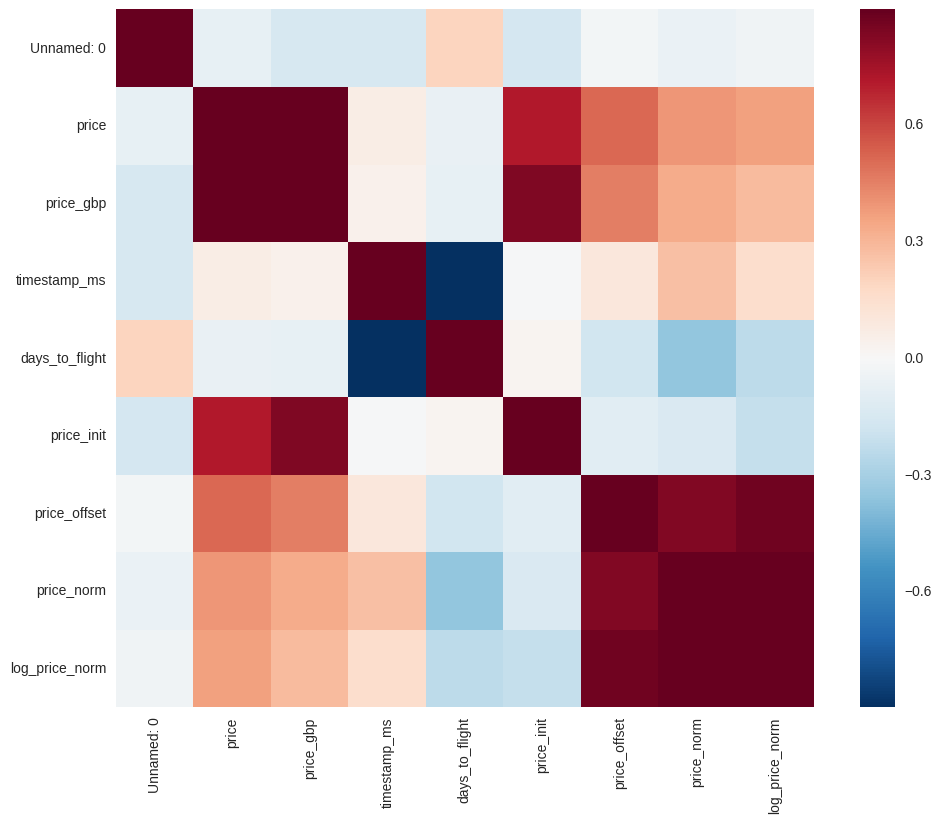

In [290]:
#correlation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

# for completeness but obviously nothing interesting here

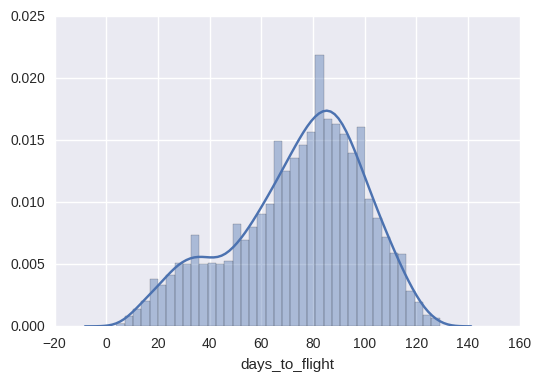

In [319]:
#histogram and normal probability plot
sns.distplot(data['days_to_flight']);
fig = plt.figure()

## Time series analysis of prices
How much spread is there around the mean price?

/home/ira/code/envs/flexi/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  app.launch_new_instance()
/home/ira/code/envs/flexi/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


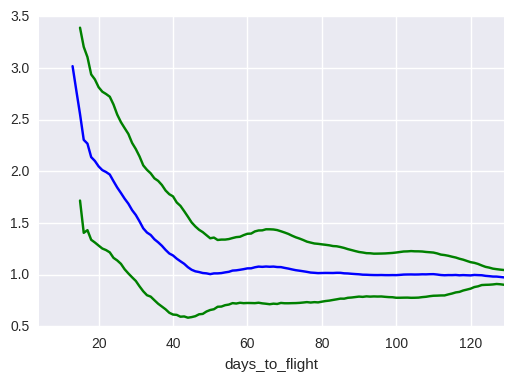

In [364]:
days_group = data.groupby('days_to_flight')
# rolling average added for smoother plot
means = pd.rolling_mean(days_group['price_norm'].mean(), 10)
bars = pd.rolling_mean(np.sqrt(days_group['price_norm'].var()), 10)

means.plot(c='b')
(means + bars).plot(c='g')
(means - bars).plot(c='g')

Naive bars -- assume that price spread is Gaussian -- untrue. See below how skew of the distribution differs after log transformation. Actually, price_norm is very close to 0, i.e. Gaussian is a good approximation.
https://en.wikipedia.org/wiki/Skew_normal_distribution

/home/ira/code/envs/flexi/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=15,center=False).mean()
  if __name__ == '__main__':
/home/ira/code/envs/flexi/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=15,center=False).mean()
  from ipykernel import kernelapp as app
/home/ira/code/envs/flexi/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=15,center=False).mean()
  app.launch_new_instance()


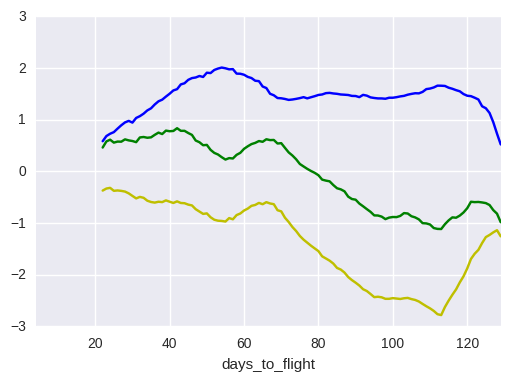

In [365]:
pd.rolling_mean(days_group['log_price_norm'].skew(), 15).plot(c='y')
pd.rolling_mean(days_group['price_norm'].skew(), 15).plot(c='g')
pd.rolling_mean(days_group['price_gbp'].skew(), 15).plot(c='b')

Box plot below tells the same story, the distribution is fairly symmetric. Compare to what the distribution looks like for unnormalised price_gbp

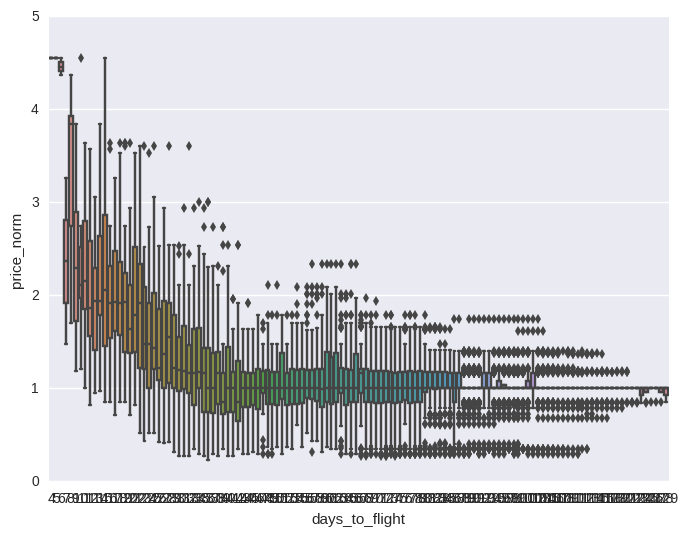

In [357]:
var_ctrl = 'days_to_flight'
var_dep = 'price_norm'
# var_dep = 'price_gbp'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var_ctrl, y=var_dep, data=data)

**It seems price is not expected to increase (given only days_left) until 50 days to flight**